# Atmospheric Turbulence

Simulation of atmospheric turbulence's effects on point image source

From http://www.roe.ac.uk/roe/workshop/2011/presentations/tue-pm3-richard-wilson.pdf

- Create 2D array of random complex numbers, normal distribution, mean=0, variance=1
- Phase power spectrum: $\phi(k) = 0.0229r_{0}^{\frac{5}{3}}k^{\frac{-11}{3}}$
- Multiply random numbers by $\sqrt{\phi(k)}$
- FFT to get array of phase fluctuations

Following Matlab example simulation here:  http://www.activeopticalsystems.com/docs/AN021_Kolmogorov%20Spectrum%20Turbulence%20Analysis.pdf

In [1]:
# Includes
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import fftconvolve
from scipy.signal import argrelextrema

%matplotlib inline

## Parameters
# Image specs
nxy = 512
center = int(nxy/2)

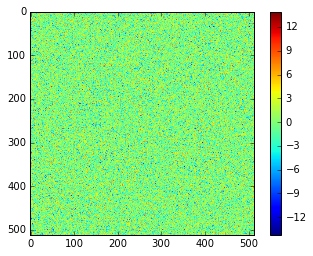

In [2]:
# Generate random image
# To be used in creating random atmospheric element
phase_phase = np.multiply(np.pi,np.random.normal(loc=0,scale=1,size=(nxy,nxy)))
plt.figure()
plt.imshow(phase_phase)
plt.colorbar()

/home/niels/anaconda3/envs/speckle/lib/python3.5/site-packages/ipykernel/__main__.py:75: RuntimeWarning: divide by zero encountered in power


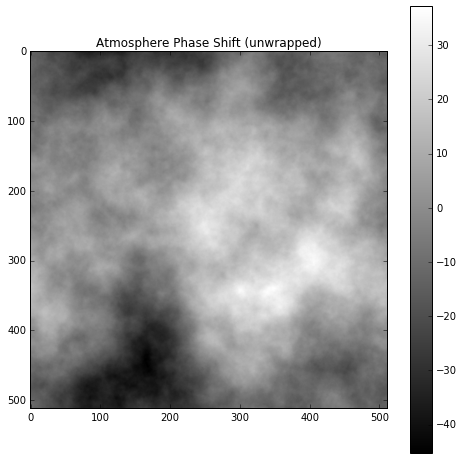

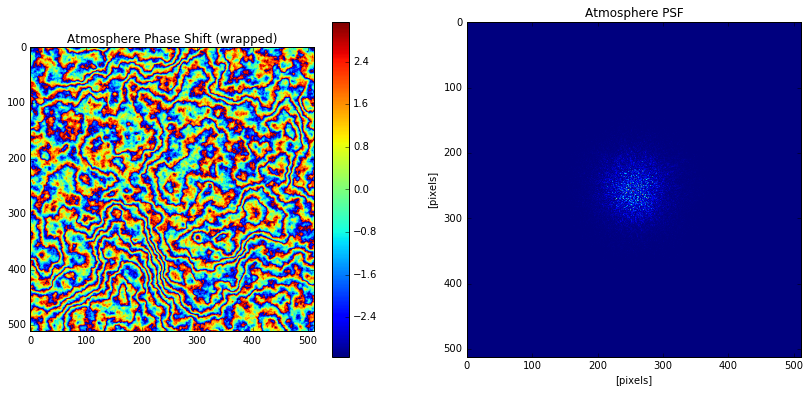

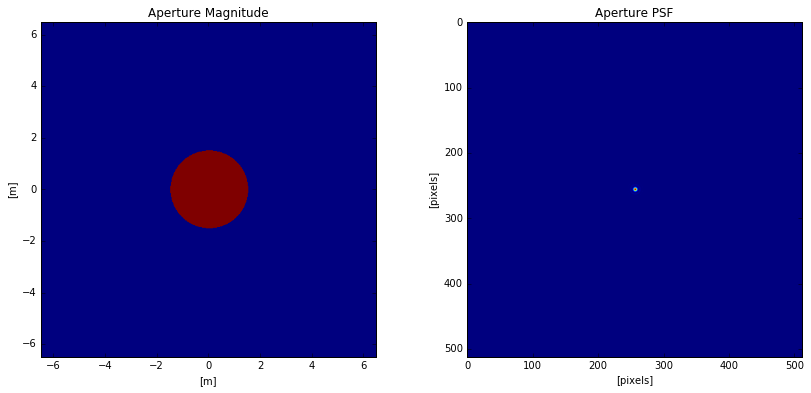

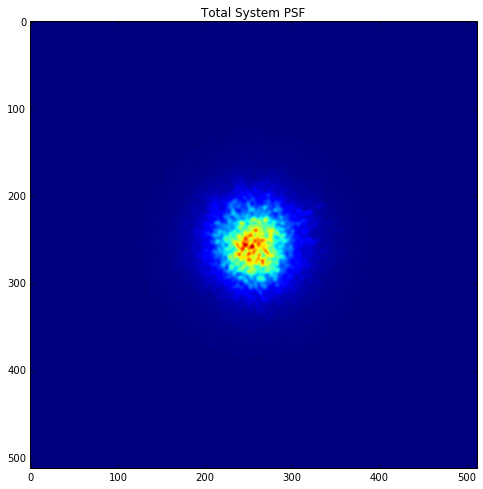

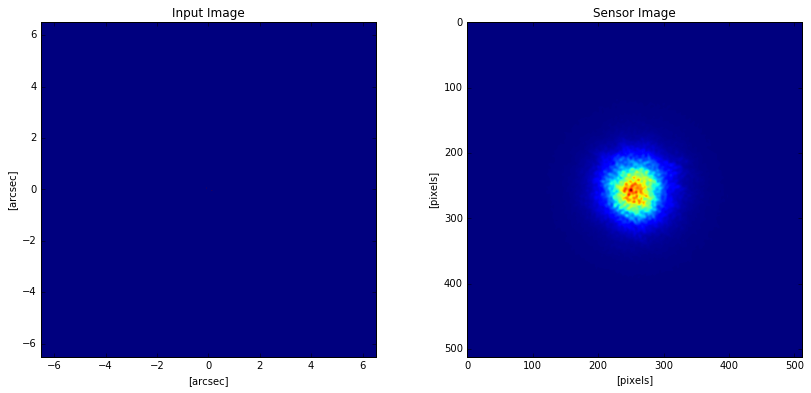

In [3]:
# Aperture/Telescope Specifications:
diameter_m = 2.133 # Mirror diameter in meters
focal_length = 129.69 # Effective focal length in meters
wavelength = 0.8E-6 # Wavelength of light
pixel = 8E-6 # Dimension of a pixel
diameter_m = 3 # Telescope diameter in m

## Creating Binary Star Input Image
# For KP 2.1m telescope, input image is in units of 25.44 milliarcseconds
platescale = 0.02544 # Plate scale in arcsec/pixel
rho = 0.25 # Set separation in arcseconds
phi = 30 # Set angle in degrees
# Calculate coordinates of stars
x = int( rho/(2*platescale) * np.cos(np.deg2rad(phi)) )
y = int( rho/(2*platescale) * np.sin(np.deg2rad(phi)) )
x1 = center + x
y1 = center + y
x2 = center - x
y2 = center - y    
# Empty input image
input_img = np.zeros((nxy,nxy)) 
# Place stars on image
input_img[y1,x1] = 1 
input_img[y2,x2] = 1
# Scale image power to 1
input_img_power = np.sum(np.power(input_img,2))
input_img = np.divide(input_img,np.sqrt(input_img_power))


## Telescope aperture creation:
# Total spatial sample range
X_aperture_s = 1/pixel 
# dx value for sampled aperture image
dx_aperture_s = X_aperture_s/nxy 
# Coordinates of sampled image
x_aperture_s = np.arange(0,X_aperture_s,dx_aperture_s) - X_aperture_s/2
# Meshgrid of sampled coordinates
xx_s,yy_s = np.meshgrid(x_aperture_s,x_aperture_s)
# Scaled aperture diameter to effectively resample aperture image
diameter_s = diameter_m/(focal_length*wavelength)
# Draw new circle at correct dimensions
# Calculate grid of distances from circle center
circle_s = (xx_s) ** 2 + (yy_s) ** 2 
# Draw boolean circle
circle_s = circle_s < (diameter_s/2)**2 
# Convert boolean circle to int
circle_s= circle_s.astype(np.int64)
# Save aperture image in units of meters
aperture_screen_s = circle_s
# Scale aperture image power to 1
aperture_screen_power = np.sum(np.power(aperture_screen_s,2))
aperture_screen_s = np.divide(aperture_screen_s,np.sqrt(aperture_screen_power))
# Calculate effective size of sampled aperture image in meters
X_aperture_s_meff = focal_length*wavelength/pixel

## Phase screen creation:
# Total array sample size
d_aperture = X_aperture_s_meff
# Fried parameter [m]
r0 = 0.2
# Spatial sample resolution
dxy = d_aperture/nxy
# Spatial frequency resolution
df = 1/(d_aperture) 
# Image sample indices array
x = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), dxy )
# Spatial Frequency indices array
xf = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), df )
# Meshgrid of spatial frequency domain
[xx,yy]=np.meshgrid(xf,xf)
# Radius from center meshgrid
rr = (np.sqrt(np.power(xx,2)+np.power(yy,2)))
# Calculate Kolmogorov spectral density
alpha = 1/64
phase_PSD = np.power(rr,-11/3)
phase_PSD = np.multiply(alpha*0.023/(r0**(5/3)),phase_PSD)
# Set DC component to 0 (previous calc attempts to set to 1/0)
phase_PSD[int(nxy/2),int(nxy/2)] = 0 
# Construct phase screen spectrum
phase_screen_f = np.multiply(np.sqrt(phase_PSD),np.exp(1j*phase_phase))
# Calculate phase screen
phase_screen = np.real(ifft2(fftshift(phase_screen_f)*nxy*nxy))

# Create complex phase screen
atmosphere_screen = np.exp(np.multiply(1j,phase_screen))

## Calculate Atmospheric Diffraction pattern
# Calculate normalized complex diffraction pattern
atmosphere_psf = fftshift(fft2(atmosphere_screen))
# Calculate PSF of complex diffraction pattern
atmosphere_psf = np.power(np.abs(atmosphere_psf),2)

## Calculate Aperture Diffraction pattern
# Calculate normalized complex diffraction pattern
aperture_psf = fftshift(fft2(aperture_screen_s))
# Calculate PSF of complex diffraction pattern
aperture_psf = np.power(np.abs(aperture_psf),2)

## Calculate system's total response 
# Calculate total PSF of system
psf = fftconvolve(atmosphere_psf,aperture_psf)
# Save center 512x512 image
psf = psf[center:center+nxy,center:center+nxy] 
# Gamma correcting PSF
gamma = 1
psf = np.power(np.divide(psf,psf.max()),gamma)

# Convolve atmosphere PSF with input image using FFT
sensor_img = fftconvolve(input_img,psf)
# Save the center 512x512 image
sensor_img = sensor_img[center:center+nxy,center:center+nxy] 

##Plots
colormap = "jet"

plt.figure(figsize = (8,8), dpi = 200)
plt.imshow(phase_screen, cmap="gray")
plt.title("Atmosphere Phase Shift (unwrapped)")
plt.colorbar()

plt.figure(figsize = (14,6), dpi = 200)
plt.subplot(1,2,1)
plt.imshow(np.angle(atmosphere_screen), cmap=colormap)
plt.colorbar()
plt.title("Atmosphere Phase Shift (wrapped)")
plt.subplot(1,2,2)
plt.imshow(atmosphere_psf, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Atmosphere PSF")

plt.figure(figsize = (14,6), dpi = 200)
plt.subplot(1,2,1)
plt.imshow(aperture_screen_s, cmap=colormap, 
           extent = (-X_aperture_s_meff/2,X_aperture_s_meff/2,
                     -X_aperture_s_meff/2,X_aperture_s_meff/2))
plt.title("Aperture Magnitude")
plt.xlabel("[m]")
plt.ylabel("[m]")
plt.subplot(1,2,2)
plt.imshow(aperture_psf, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Aperture PSF")

plt.figure(figsize = (8,8), dpi = 200)
plt.imshow(psf, cmap=colormap)
plt.title("Total System PSF")

plt.figure(figsize = (14,6), dpi = 200)
plt.subplot(1,2,1)
plt.imshow(input_img, cmap=colormap, extent = (-6.513,6.513,-6.513,6.513))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title("Input Image")
plt.subplot(1,2,2)
plt.imshow(sensor_img, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Sensor Image")

In [4]:
## Checking phase mask fluctuation over Fried cell
# At each point possible in the image (away from edges)
#  Save pixels within a square that bounds Fried cell
#  Mask this square by a circular mask
#  Calculate total RMS variance of masked image

# Calculate r0 in pixels
r0_p = int(np.round((r0/d_aperture)*nxy))
r0_p_center = (r0_p-1)/2


# Calculate indices to loop over
i_loop = np.arange(0,nxy-r0_p+1)
print("r0_p=",r0_p)
print("r0_p_center=",r0_p_center)
print("i_loop=",i_loop)
print("")

# Create circular mask image
xx,yy = np.meshgrid(np.arange(0,r0_p),np.arange(0,r0_p))
r0_mask = np.sqrt(np.add(np.power(xx-r0_p_center,2),np.power(yy-r0_p_center,2)))
r0_mask = 1*(r0_mask<r0_p/2)

# Create array to hold RMS variations
r0_rms = np.zeros((len(i_loop),len(i_loop)))

#test = np.zeros((nxy+10,nxy+10))
#for i in np.arange(nxy+10):
#    for j in np.arange(nxy+10):
#        test[i,j] = i+j
#print(test)


# Loop through y values
for y in i_loop:
    #Calculate bounds of Y data to be copied
    y_bounds = [y,y+r0_p-1]
    
    # Loop through x values
    for x in i_loop:
        x_bounds = [x,x+r0_p-1]

        # Mask nearby values to new image
        phase_masked = phase_screen[y_bounds[0]:y_bounds[1]+1,x_bounds[0]:x_bounds[1]+1]
        phase_masked = np.multiply(phase_masked,r0_mask)  
        

        # Calculate RMS variation of masked image
        r0_rms[y,x]=np.power(np.mean(np.power(phase_masked,2)),0.5)
#        print(r0_rms[i,j])

r0_rms_avg = np.mean(r0_rms)
print(r0_rms_avg)



r0_p= 8
r0_p_center= 3.5
i_loop= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 2

In [5]:
np.shape(phase_masked)

(8, 8)

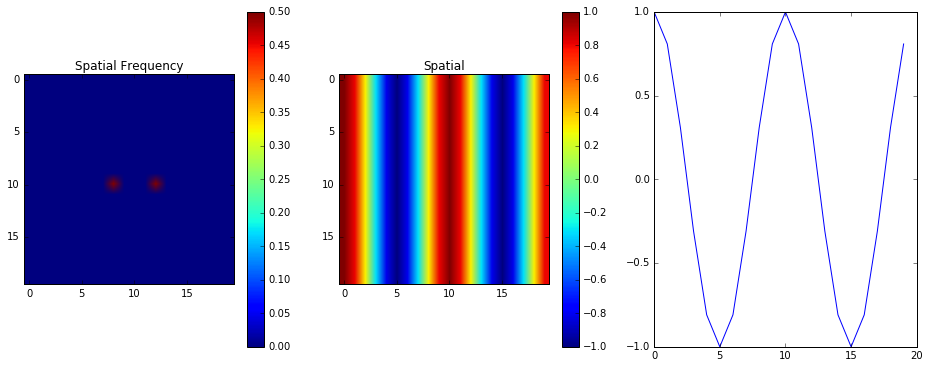

In [6]:
# Checking sanity on FFT knowledge. 
# I believe each index = 1/D, D = sample distance

# Create empty frequency spectrum
size = 20
test_f = np.zeros((size,size))

# Assign values in frequency spectrum
k = 2
test_f[int(size/2),int(size/2)+k] = 0.5
test_f[int(size/2),int(size/2)-k] = 0.5

# IFFT to get image
test = np.real(ifft2(fftshift(test_f))*size*size)

# Display Spectrum and Image
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(test_f)
plt.colorbar()
plt.title("Spatial Frequency")

plt.subplot(1,3,2)
plt.imshow(test)
plt.colorbar()
plt.title("Spatial")

plt.subplot(1,3,3)
plt.plot(test[int(size/2),:])

# As expected, the period of the SIN wave in image is 
# T = 1/k
# Or the frequency component of F = 2 is creted by k = 2